In [5]:
# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load data
input_data = np.load('../../WaveSuite/regularWave_pcs_U_data_0_to_131.npy')
output_data = np.load('../../WaveSuite/regularWave_pcs_nut_data_0_to_131.npy')
print(input_data.shape)
# Ensure data is in float32 format
input_data = input_data.astype(np.float32)
output_data = output_data.astype(np.float32)

min_input = np.min(input_data)
max_input = np.max(input_data)
min_output = np.min(output_data)
max_output = np.max(output_data)
min = -1
max = +1

def scaler(x, xmin, xmax, min, max):
    scale = (max - min) / (xmax - xmin)
    xScaled = scale * x + min - xmin * scale
    return xScaled

input_scaled = scaler(input_data, min_input, max_input, min, max)
output_scaled = scaler(output_data, min_output, max_output, min, max)

# Train/Test split
input_train, input_test, output_train, output_test = train_test_split(input_scaled, 
                                                                      output_scaled, 
                                                                      test_size=0.2, 
                                                                      shuffle=True, 
                                                                      random_state=42)

# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(torch.from_numpy(input_train), torch.from_numpy(output_train))
test_dataset = TensorDataset(torch.from_numpy(input_test), torch.from_numpy(output_test))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(131, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc31 = nn.Linear(128, 16)  # Mean μ
        self.fc32 = nn.Linear(128, 16)  # Log of variance σ (logvar)

        # Decoder
        self.fc4 = nn.Linear(16, 128)
        self.fc5 = nn.Linear(128, 512)
        self.fc6 = nn.Linear(512, 131)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc4(z))
        h4 = F.relu(self.fc5(h3))
        return torch.tanh(self.fc6(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 131))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, target, mu, logvar):
    MSE = F.mse_loss(recon_x, target.view(-1, 131), reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

# Initialize model and optimizer
model = VAE().cuda()  # Add .cuda() to move model to GPU
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Initialize list to store losses
train_losses = []
test_losses = []

# Training loop
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()  # Move data to GPU
        target = target.cuda()  # Move target to GPU
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, target, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        # if batch_idx % 100 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader),
        #         loss.item() / len(data)))

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    if epoch % 100 == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, avg_train_loss))

# Test loop
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data = data.cuda()  # Move data to GPU
            target = target.cuda()  # Move target to GPU
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, target, mu, logvar).item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    if epoch % 100 == 0:
        print('====> Test set loss: {:.4f}'.format(avg_test_loss))

# Run training and test loops
num_epochs = 5000
for epoch in range(0, num_epochs + 1):
    train(epoch)
    test(epoch)


(131, 131)
====> Epoch: 0 Average loss: 35.8680
====> Test set loss: 22.7101
====> Epoch: 100 Average loss: 0.5522
====> Test set loss: 0.4485
====> Epoch: 200 Average loss: 0.4563
====> Test set loss: 0.3790
====> Epoch: 300 Average loss: 0.4416
====> Test set loss: 0.3572
====> Epoch: 400 Average loss: 0.4392
====> Test set loss: 0.3593
====> Epoch: 500 Average loss: 0.4255
====> Test set loss: 0.3435
====> Epoch: 600 Average loss: 0.4160
====> Test set loss: 0.3415
====> Epoch: 700 Average loss: 0.4150
====> Test set loss: 0.3402
====> Epoch: 800 Average loss: 0.4100
====> Test set loss: 0.3393
====> Epoch: 900 Average loss: 0.4125
====> Test set loss: 0.3397
====> Epoch: 1000 Average loss: 0.4127
====> Test set loss: 0.3410
====> Epoch: 1100 Average loss: 0.4139
====> Test set loss: 0.3308
====> Epoch: 1200 Average loss: 0.4104
====> Test set loss: 0.3348
====> Epoch: 1300 Average loss: 0.4092
====> Test set loss: 0.3341
====> Epoch: 1400 Average loss: 0.4115
====> Test set loss: 0

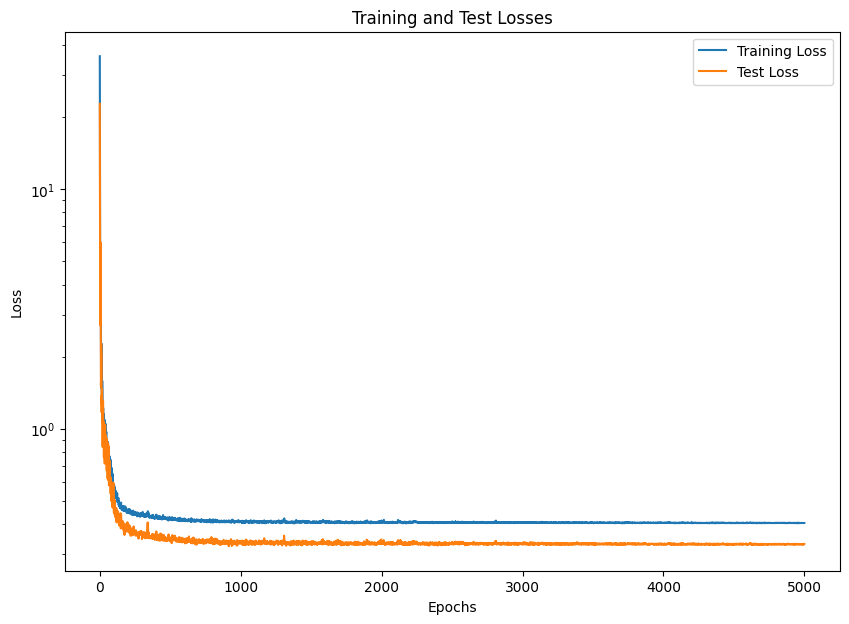

In [6]:
# Plot training and test losses
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.title('Training and Test Losses')
plt.show()

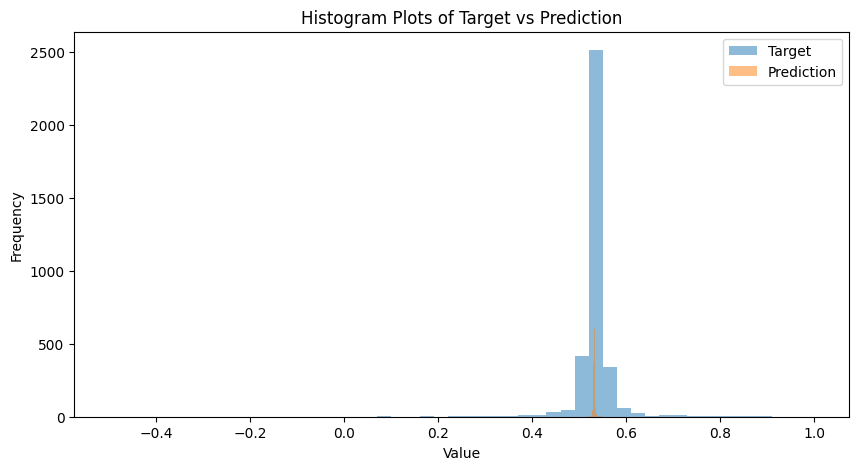

In [7]:
# Set model to evaluation mode
model.eval()

# Lists to store target and predicted values
targets = []
predictions = []

# Iterate over test data
with torch.no_grad():
    for data, target in test_loader:
        data = data.cuda()
        target = target.cuda()
        recon_batch, _, _ = model(data)
        targets.append(target.view(-1).cpu().numpy())
        predictions.append(recon_batch.view(-1).cpu().numpy())

# Concatenate targets and predictions into numpy arrays
targets = np.concatenate(targets)
predictions = np.concatenate(predictions)

# Create histogram plots
plt.figure(figsize=(10, 5))
plt.title("Histogram Plots of Target vs Prediction")
plt.hist(targets, bins=50, alpha=0.5, label='Target')
plt.hist(predictions, bins=50, alpha=0.5, label='Prediction')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

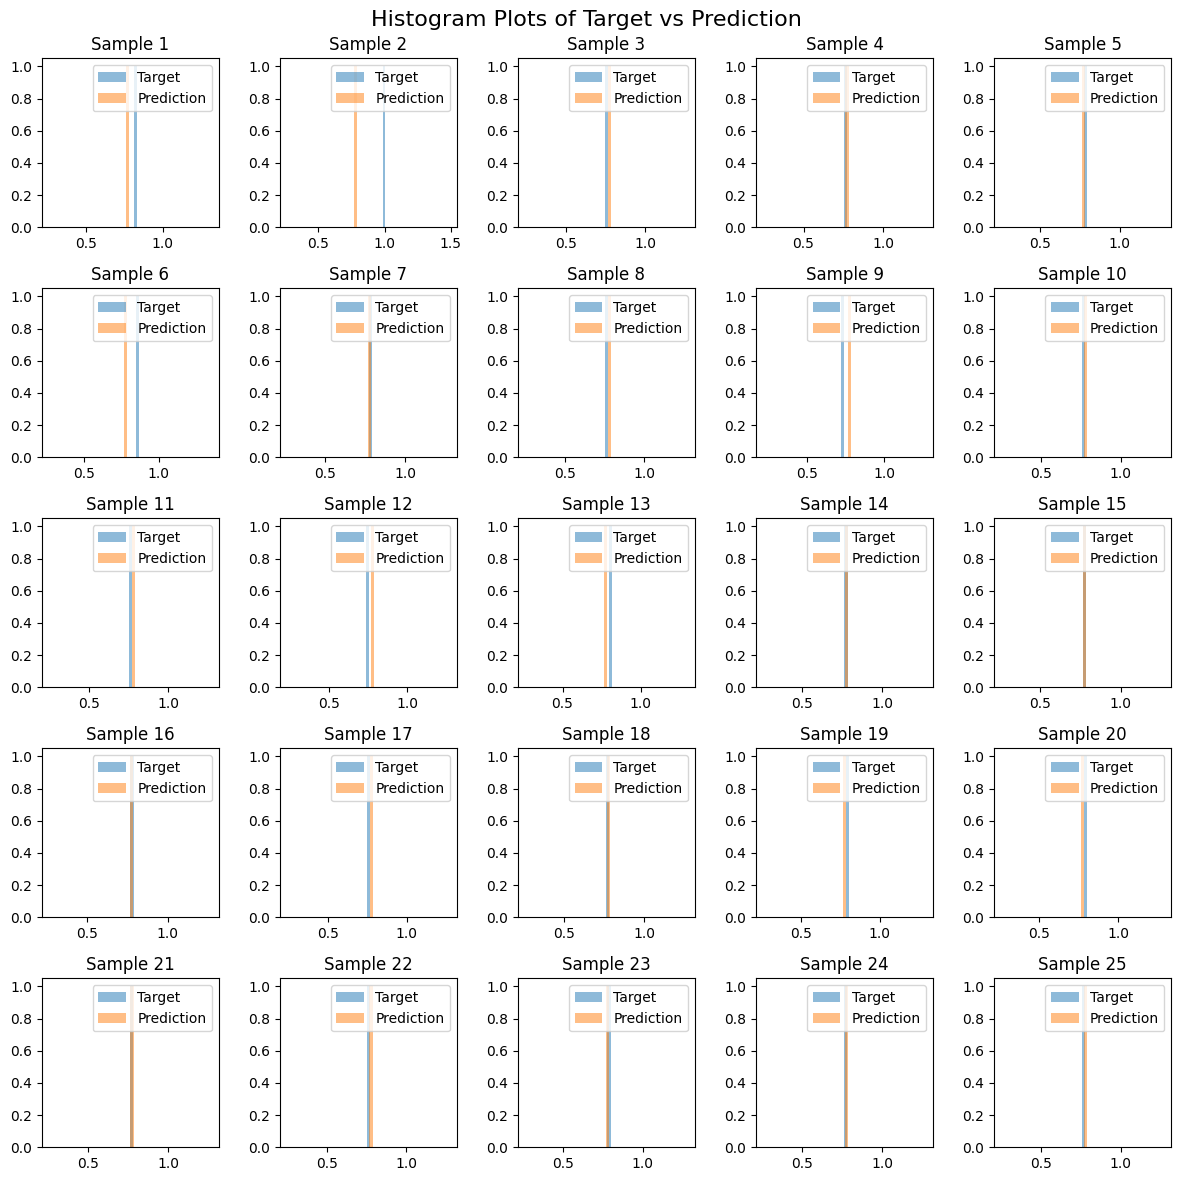

In [16]:
# Set model to evaluation mode
model.eval()

# Lists to store target and predicted values
targets = []
predictions = []

# Iterate over test data
with torch.no_grad():
    for data, target in test_loader:
        data = data.cuda()
        target = target.cuda()
        recon_batch, _, _ = model(data)
        targets.append(target.view(-1).cpu().numpy())
        predictions.append(recon_batch.view(-1).cpu().numpy())

# Concatenate targets and predictions into numpy arrays
targets = np.concatenate(targets)
predictions = np.concatenate(predictions)

# Create grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))
fig.suptitle("Histogram Plots of Target vs Prediction", fontsize=16)

# Iterate over subplots and plot histograms
for i, ax in enumerate(axes.flat):
    ax.hist(targets[i], bins=50, alpha=0.5, label='Target')
    ax.hist(predictions[i], bins=50, alpha=0.5, label='Prediction')
    ax.set_title(f"Sample {i+1}")
    ax.legend()

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()
